<a href="https://colab.research.google.com/github/ChangED1122/Python/blob/Python-PyTorch/PyTorch_Image_Classification_Custom_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
!pip install wget
import wget

url = "https://github.com/ChangED1122/Python/raw/main/one_piece_mini.zip"
wget.download(url)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


'one_piece_mini (1).zip'

In [55]:
import zipfile

with zipfile.ZipFile("one_piece_mini.zip","r") as zip_file:
  zip_file.extractall("one_piece_mini") #解壓縮

In [56]:
with open("one_piece_mini/classnames.txt","r") as f :
  lines = f.readlines()
  classes = [line.strip("\n") for line in lines] #使用strip()將 \n 移除
  print(classes) #取得種類

['Luffy', 'Nami', 'Zoro']


In [57]:
from torch.utils.data import Dataset
from pathlib import Path
from PIL import Image
from torchvision import transforms

class ImageDataset(Dataset):  #創建類別，繼承Dataset
  def __init__(self, root, train, transform=None): #初始化

    if train:
      image_root = Path(root) / "train"
    else :
      image_root = Path(root) / "test"

    with open(Path(root)/ "classnames.txt","r") as f :
      lines = f.readlines()
      self.classes = [line.strip("\n") for line in lines] #classes=所有類別的列表，使用strip()將 \n 移除

    self.paths = [i for i in image_root.rglob("*") if i.is_file()]  #所有圖片路徑
    self.transform = transform
    
  
  def __getitem__(self, index):
    img = Image.open(self.paths[index]).convert("RGB")
    class_name = self.paths[index].parent.name #取得資料夾名稱（角色名）
    class_idx = self.classes.index(class_name) #取得角色之類別索引

    if self.transform:
      return self.transform(img), class_idx 
    else:
      return img, class_idx

    
  def __len__(self):
    return len(self.paths) #回傳圖片張數
    

In [58]:
# resize = transforms.Resize((64,64)) #調整圖片大小
# totensor = transforms.ToTensor()  #轉換成tensor格式
# resize(x)
# totensor(resize(x)).shape

train_transforms = transforms.Compose([ #把以上指令結合
    transforms.Resize((64,64)),
    transforms.TrivialAugmentWide(), # 隨機幫圖片做轉換 只要在訓練集做轉換就好
    transforms.ToTensor()
])

test_transforms = transforms.Compose([ 
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [59]:
train_dataset = ImageDataset(root = "one_piece_mini", train=True, transform = train_transforms)
train_dataset.classes
x, y = train_dataset[0] #回傳圖片和人物索引
x.shape, y  # 0=Luffy 1=Nami 2=Zoro

(torch.Size([3, 64, 64]), 2)

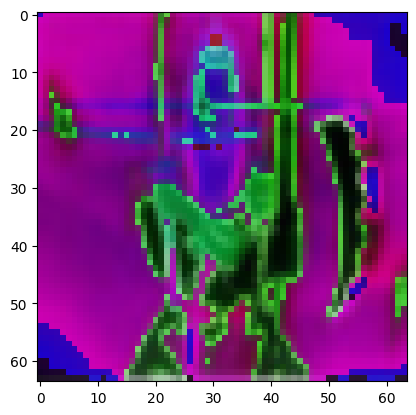

In [60]:
import matplotlib.pyplot as plt
# 圖片轉換後的結果
x, y = train_dataset[0] #每次執行都有不同結果
plt.imshow(x.permute(1,2 ,0)) # plt的最後維度要是色彩

In [61]:
train_dataset = ImageDataset(root = "one_piece_mini",
                             train=True, 
                             transform = train_transforms)
test_dataset = ImageDataset(root = "one_piece_mini",
                             train=False, 
                             transform = test_transforms)

In [62]:
len(train_dataset), len(test_dataset)

(240, 60)

one_piece_mini/train/Zoro/59.jpg


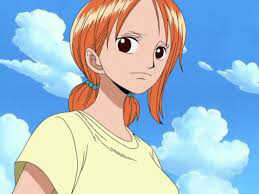

In [63]:
image_root = Path("one_piece_mini") / "train"
image_root.rglob("*")  #讀取 Path("one_piece_mini") / "train" 路徑下所有資料夾和所有檔案的路徑

# for i in image_root.rglob("*"):
#   if i.is_file():  #只印出資料夾內的檔案
#       print(i)

from PIL import Image
path = [i for i in image_root.rglob("*") if i.is_file()] #簡潔寫法
print(path[0]) # 共240張,80*3

Image.open(path[100]).convert("RGB")

創建 DataLoader

In [64]:
from torch.utils.data import DataLoader

BATCH_SIZE = 8

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

In [65]:
len(train_dataloader) , len(test_dataloader)  # 240/8 , 60/8

(30, 8)

In [66]:
x_first_batch,y_first_batch = next(iter(train_dataloader))
x_first_batch.shape,y_first_batch

(torch.Size([8, 3, 64, 64]), tensor([1, 1, 1, 0, 0, 0, 2, 2]))

In [67]:
from torch import nn
class ImageClassificationModel3(nn.Module):
  def __init__(self, input_shape, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape,
                out_channels=8, 
                kernel_size=(3,3), 
                stride=1, 
                padding=1
      ),
      nn.ReLU(),
      nn.Conv2d(in_channels=8,
                out_channels=8, 
                kernel_size=(3,3), 
                stride=1, 
                padding=1
      ),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2,2), 
                   stride=2, 
                   padding=0
      )
    )
    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels=8,
                out_channels=16, 
                kernel_size=(3,3), 
                stride=1, 
                padding=1
      ),
      nn.ReLU(),
      nn.Conv2d(in_channels=16,
                out_channels=16, 
                kernel_size=(3,3), 
                stride=1, 
                padding=1
      ),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2,2), 
                   stride=2, 
                   padding=0
      )
    )
    self.classifier = nn.Sequential(
        nn.Flatten(start_dim=1,end_dim=-1), #預設是（1,-1）這樣沒有全部攤平
        nn.Linear(in_features=16*16*16, out_features=output_shape) #如果不知道in_features要填多少，可以先跑block_1&block_2
        #nn.Softmax()  因為torch的 CrossEntropy已經包含 Softmax()
    )
    

  def forward(self,x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x


In [68]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

經前面兩層操作 self.conv_block_1(x) and self.conv_block_2(x)

知道torch.Size([8, 16, 16, 16]) 也就是in_feature 填入16＊16＊ 16

In [69]:
model = ImageClassificationModel3(3, len(train_dataset.classes)) #input_shape彩色圖片 =3 , output_shape Y的類別
model.to(device)
model(x_first_batch.to(device))

tensor([[-0.0585,  0.0283, -0.0107],
        [-0.0581,  0.0345, -0.0177],
        [-0.0670,  0.0307, -0.0128],
        [-0.0593,  0.0221, -0.0110],
        [-0.0722,  0.0294, -0.0047],
        [-0.0764,  0.0431, -0.0157],
        [-0.0555,  0.0216, -0.0171],
        [-0.0713,  0.0266, -0.0080]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [70]:
cost_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001) 

Adam和SGD差異：

SGD整個訓練過程學習率不變

Adam在學習過程中都會幫我們調整 ，0.001只是初始學習率

In [71]:
def accuracy_fn(y_pred, y_true):
  correct_num = ( y_pred==y_true).sum()
  acc = correct_num/len(y_true) *100
  return acc

In [72]:
def train_step(dataloader, model, cost_fn, optimizer, accuracy_fn, device): #訓練步驟
   train_cost = 0
   train_acc = 0

   for batch, (x, y) in enumerate(dataloader):  # enumerate( ) 知道第幾個batch
    x= x.to(device)
    y= y.to(device)
    model.train()

    y_pred = model(x)

    cost = cost_fn(y_pred, y)
    train_cost += cost   #  train_cost的值=每個batch的cost加總

    train_acc += accuracy_fn(y_pred.argmax(dim=1) ,y)

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
  
   train_cost /= len(train_dataloader)  #取平均
   train_acc /= len(train_dataloader)
   print(f"\nTrain Cost: {train_cost:.4f}, Train Acc: {train_acc:.2f}")

def test_step(dataloader, model, cost_fn, accuracy_fn, device): #測試步驟
  test_cost = 0
  test_acc = 0
  model.eval()
  with torch.inference_mode():
    for x, y in dataloader:
      x= x.to(device)
      y= y.to(device)
      test_pred = model(x)
      
      test_cost += cost_fn(test_pred, y)
      test_acc += accuracy_fn(test_pred.argmax(dim=1) ,y)

    test_cost /= len(test_dataloader)
    test_acc /= len(test_dataloader)
  
  print(f"Test  Cost: {test_cost:.4f}, Test  Acc: {test_acc:.2f}  \n")

In [73]:
from tqdm.auto import tqdm  #進度條

epochs = 25
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")
  train_step(train_dataloader, model, cost_fn, optimizer, accuracy_fn, device)

  test_step(test_dataloader, model, cost_fn, accuracy_fn, device)

  

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0
------

Train Cost: 1.1099, Train Acc: 32.50
Test  Cost: 1.0925, Test  Acc: 37.50  

Epoch: 1
------

Train Cost: 1.0933, Train Acc: 34.17
Test  Cost: 1.0760, Test  Acc: 46.88  

Epoch: 2
------

Train Cost: 1.0546, Train Acc: 49.17
Test  Cost: 1.0748, Test  Acc: 39.06  

Epoch: 3
------

Train Cost: 1.0450, Train Acc: 49.17
Test  Cost: 1.0444, Test  Acc: 51.56  

Epoch: 4
------

Train Cost: 1.0292, Train Acc: 50.42
Test  Cost: 1.0333, Test  Acc: 48.44  

Epoch: 5
------

Train Cost: 1.0199, Train Acc: 51.25
Test  Cost: 1.0053, Test  Acc: 56.25  

Epoch: 6
------

Train Cost: 1.0029, Train Acc: 54.58
Test  Cost: 0.9833, Test  Acc: 56.25  

Epoch: 7
------

Train Cost: 0.9303, Train Acc: 57.50
Test  Cost: 0.9645, Test  Acc: 56.25  

Epoch: 8
------

Train Cost: 0.9512, Train Acc: 55.00
Test  Cost: 0.9312, Test  Acc: 56.25  

Epoch: 9
------

Train Cost: 0.8565, Train Acc: 62.92
Test  Cost: 0.7063, Test  Acc: 67.19  

Epoch: 10
------

Train Cost: 0.8893, Train Acc: 55.42
Test 

這裡發現過度配適問題，訓練集過高，測試集過低  

使用Data Augmentation: 對原數據作一些轉換，創建更多訓練數據

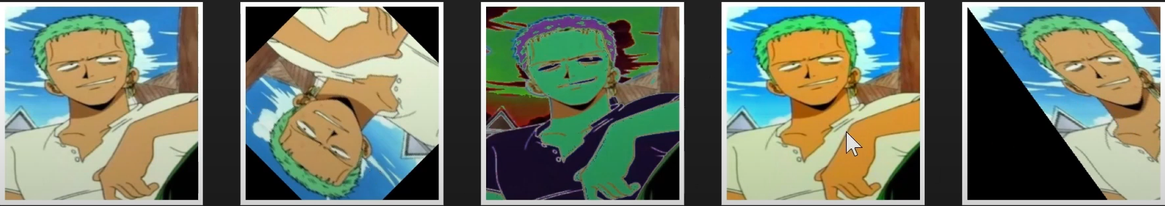



使用 transforms.TrivialAugmentWide() 在一開始更改圖片大小的地方進行轉換

In [94]:
img = Image.open("魯夫.jpg").convert("RGB") #上面怎麼讀取跟轉換這裡一樣
img
img = test_transforms(img)
img.shape
img = img.reshape(-1,3,64,64) #上面傳進去的都是(batch,3,64,64)


model.eval()
with torch.inference_mode():
  y_pred = model(img.to(device))

y_pred = torch.softmax(y_pred, dim=1) #轉換成機率
class_idx = y_pred.argmax(dim=1)
train_dataset.classes[class_idx]


'Luffy'